# Классификация текстов с активным обучением


Зададимся простой задачей классификации текстов: например, классификацией отзывов на банки по тональности. Эта задача решается с достаточно высокими показателями качества с использованием стандартных алгоритмов классификации, например, сверточных нейронных сетей: корпус состоит из достаточного количества документов, чтобы сверточная сеть хорошо обучилась. Однако возникает естественный вопрос: действительно ли все документы нужны для того, чтобы достичь таких высоких показателей качества (или сопоставимых с ними). Парадигма активного обучения поможет вам ответить на этот вопрос.

## Часть 1. Предобработка данных [2 балла]

Коллекция отзывов хранится в файле banki_responses (https://www.dropbox.com/s/ol3ux3ibr6rd5ke/banki_responses.json.bz2?dl=0). Одна строчка в этом файле соответствует одному json-словарю. Из этого словаря вам понадобятся два значения по ключам text и rating -- текст отзыва и его оценка по шкале от 1 до 5.   

Считайте файл. Посчитайте, каких отзывов больше: положительных или отрицательных? 

Проведите предварительную обработку данных: удалите слишком короткие и слишком длинные тексты (пороги на длину определите самостоятельно). 

Разбейте данные на обучающее ($train$) и тестовое ($test$) множество случайным образом в отношеннии 3:1 (или любом другом отношении, которое покажется вам разумным). 

Задача классификации сформулирована так: по каждому отзыву определить его оценку (т.е. классификация на 5 классов). Признаками для классификации выступают слова.

136189


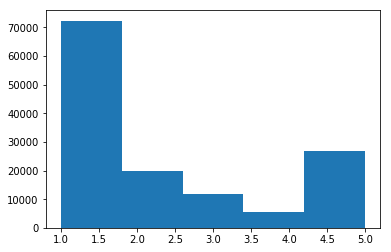

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

texts = []
grades = []
with open('./banki_responses.json', 'r') as f:
    for line in f:
        parsed = json.loads(line.strip())
        if parsed['rating_grade'] is not None: # delete responses without grade
            texts.append(parsed['text'])
            grades.append(parsed['rating_grade'])
texts = np.array(texts)
grades = np.array(grades)
print(len(texts))
plt.hist(grades, 5)
plt.show()

In [2]:
print(len(grades[grades < 3]), len(grades[grades > 3]))

92235 32252


> Видно, что негативные отзывы преобладают почти в три раза

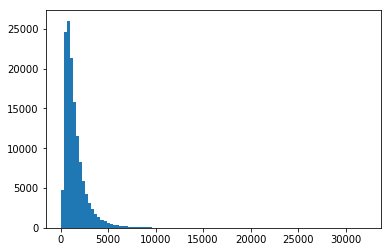

In [3]:
plt.hist(list(map(len, texts)), bins=100)
plt.show()

> отсечем тексты, длины которых находятся после 90-перцентили и до 10-перцентили, потому что они слишком короткие, либо слишком длинные. Оставим 80% выборки

In [4]:
from scipy.stats.mstats import mquantiles
texts_lens = np.array(list(map(len, texts)))
low, high = mquantiles(texts_lens, [0.1, 0.9])
print(low, high)

472.0 2913.0


In [5]:
mask = (texts_lens >= low) & (texts_lens <= high)
texts = texts[mask]
grades = grades[mask]
len(texts)

109017

> разбивать на train и test логичнее перед обучением, после генерации признаков

## Часть 2. Baseline [4 балла]

Получите baseline классификации: в идеале, используйте сверточную нейронную сеть (слой эмбеддингов + свертка + субдескритизация). Число и размерность фильтров определите самостоятельно, так же как и использование регуляризаторов (dropout / batch norm) и их параметров. Так же самостоятельно (но обосновано) решите, использовать ли вам предобученные эмбеддинги или нет и проводить ли вам лемматизацию или нет. 

Обучите сеть на обучающем множестве и протестируйте на тестовом. Зафиксируйте baseline.

Если совсем трудно или вычисления занимают слишком много времени, используйте любой другой известный и симпатичный вам алгоритм классификации. 

> В большинстве задач выбор эмбеддингов слабо влияет на качество: их учат таким образом, чтобы они подходили для всех задач. 

> В качестве алгоритма классификации будем использовать сеть с одним полносвязным слоем.

> В качестве признаков будем использовать среднее арифметические эмбеддингов слов. Лемматизацию проводить бессмысленно, так как слова берутся независимо

> Избавимся от стоп-слов, так как смысловой нагрузки они не несут, а на итоговые эмбеддинги влияют

In [6]:
# cleaning
import stop_words
ru_stop_words = stop_words.get_stop_words('russian')
import re
rewords = re.compile('[а-яА-ЯёЁ]+')
clean = lambda word : word not in ru_stop_words
lower = lambda word : word.lower()

words = np.array(list(map(lambda text: list(filter(clean, map(lower, rewords.findall(text)))), texts)))
words_len = np.array(list(map(len, words)))

mask = words_len > 0
words = words[mask]
grades = grades[mask]

> Будем использовать предобученные fastText эмбеддинги из второго задания.

In [ ]:
import fastText
embeddings_model = fastText.load_model('./wiki.ru.bin')

def get_embeddings(words):
    embeddings = np.array(list(map(lambda word : embeddings_model.get_word_vector(word), words)))
    return embeddings.mean(axis=0)

In [8]:
embeddings = np.array(list(map(get_embeddings, words)))
embeddings.shape

(109015, 300)

In [9]:
import keras
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

/Users/tkhismatullin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
NUM_CLASSES = 5
def build_model(n_h, act):
    model = Sequential()
    model.add(Dense(n_h, activation=act, input_shape=(embeddings_model.get_dimension(),)))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

In [11]:
baseline_model = build_model(128, 'relu')

In [12]:
baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

> поделим на train и test таким образом, чтобы в обеих частях было одинаковое распределение оценок, в соотношении 3:1

In [13]:
from sklearn.model_selection import train_test_split
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(embeddings, grades-1, test_size=test_size, shuffle=True, stratify=grades)

In [14]:
baseline_model.fit(X_train, y_train, batch_size=64, epochs=1000, validation_split=0.1, \
          callbacks=[keras.callbacks.EarlyStopping('val_acc')])

Train on 73584 samples, validate on 8177 samples
Epoch 1/1000
73584/73584 [==============================] - 2s 29us/step - loss: 0.9988 - acc: 0.6484 - val_loss: 0.9179 - val_acc: 0.6767
Epoch 2/1000
73584/73584 [==============================] - 2s 24us/step - loss: 0.9196 - acc: 0.6734 - val_loss: 0.8986 - val_acc: 0.6804
Epoch 3/1000
73584/73584 [==============================] - 2s 24us/step - loss: 0.9076 - acc: 0.6764 - val_loss: 0.9060 - val_acc: 0.6787


In [15]:
_, accuracy = baseline_model.evaluate(X_test, y_test)
print(accuracy)

27254/27254 [==============================] - 1s 20us/step
0.6741395758595743


---
# Baseline: 0.6741 accuracy
---

## Часть 3. Baseline [4 балла] Активное обучение

Подход активного обучения основан на следующей идее: вместо всего обучающего множества мы используем его маленькие фрагменты, в которых модель неуверена для обучения. Таким образом, модель обучается исключительно по **трудным** объектам, число которых существенно меньше, чем общее число объектов.

Обучение модели начинается с обучения по $N$ случайно выбранным примерам, где $N$ – небольшое число (100, 200 и т.д.). Затем модель тестируется на $|train| - N$ объектах, после чего из  $|train| - N$ объектов выбираются снова $N$  объектов, в которых модель не уверена. Эти объекты используются для дообучения модели. Процесс выбора $N$ трудных объектов и дообучения на них повторяется некоторое количество раз (100, 200 и т.д. раз). На каждом шаге активного обучения модель можно протестировать на тестовом множестве, чтобы сравнить ее качества с baseline.

Как выбирать трудные объекты:
1. Выход нейронной сети - оценки 5 вероятностей принадлежности объекта одному из классов. Предсказанный класс – это тот класс, вероятность которого максимальна. Отсортируем объекты по убыванию вероятности предсказанного класса ($\min \max p_i$) и выберем $N$ первых объектов;
2. Используем энтропию: чем больше энтропия предсказания, тем ближе распределение вероятностей предсказания к равномерному распределению, тем труднее объект. 

In [63]:
BATCH_SIZE = 200
N_STEPS = 200
active_learning_model = build_model(128, 'relu')
active_learning_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

> трудным объектом примем тот, у которого максимум среди предсказаний вероятностей классов маленький.

In [64]:
remaining_samples = np.arange(len(X_train))
chosen = np.random.choice(remaining_samples, BATCH_SIZE, replace=False)
remaining_samples = remaining_samples[~np.isin(remaining_samples, chosen)]

active_learning_model.fit(X_train[chosen], y_train[chosen])
accuracies = [active_learning_model.evaluate(X_test, y_test)[1]]
for step in range(N_STEPS):
    # predict on train
    predicted = active_learning_model.predict_proba(X_train[remaining_samples])
    # get max predicted probability on each case
    predicted_max = predicted.max(axis=1)
    # get batch with the least max probability
    batch_mask = remaining_samples[predicted_max.argsort()[:BATCH_SIZE]]
    # fit model
    active_learning_model.fit(X_train[batch_mask], y_train[batch_mask])
    # delete trat samples from train
    remaining_samples = remaining_samples[~np.isin(remaining_samples, batch_mask)]
    acc = active_learning_model.evaluate(X_test, y_test)[1]
    accuracies.append(acc)
    print('Step %d: accuracy on test %.4f' % (step + 1, acc))

Epoch 1/1
27254/27254 [==============================] - ETA:  - 1s 28us/step
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 1: accuracy on test 0.3109
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 2: accuracy on test 0.5727
Epoch 1/1
27254/27254 [==============================] - 1s 23us/step
Step 3: accuracy on test 0.5340
Epoch 1/1
27254/27254 [==============================] - 1s 25us/step
Step 4: accuracy on test 0.5262
Epoch 1/1
27254/27254 [==============================] - 1s 26us/step
Step 5: accuracy on test 0.2711
Epoch 1/1
27254/27254 [==============================] - 1s 26us/step
Step 6: accuracy on test 0.5728
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 7: accuracy on test 0.5461
Epoch 1/1
27254/27254 [==============================] - 1s 25us/step
Step 8: accuracy on test 0.5371
Epoch 1/1
27254/27254 [==============================] - 1s 25us/step
Step 9: accuracy on test 0.3030
Epoc

27254/27254 [==============================] - 1s 24us/step
Step 87: accuracy on test 0.6008
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 88: accuracy on test 0.6444
Epoch 1/1
27254/27254 [==============================] - 1s 23us/step
Step 89: accuracy on test 0.6408
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 90: accuracy on test 0.6471
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 91: accuracy on test 0.6488
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 92: accuracy on test 0.5499
Epoch 1/1
27254/27254 [==============================] - 1s 23us/step
Step 93: accuracy on test 0.6370
Epoch 1/1
27254/27254 [==============================] - 1s 25us/step
Step 94: accuracy on test 0.6511
Epoch 1/1
27254/27254 [==============================] - 1s 25us/step
Step 95: accuracy on test 0.6283
Epoch 1/1
27254/27254 [==============================] - 1s 24us/step
Step 96: accu

27254/27254 [==============================] - 1s 29us/step
Step 173: accuracy on test 0.6603
Epoch 1/1
27254/27254 [==============================] - 1s 26us/step
Step 174: accuracy on test 0.6618
Epoch 1/1
27254/27254 [==============================] - 1s 30us/step
Step 175: accuracy on test 0.6311
Epoch 1/1
27254/27254 [==============================] - 1s 27us/step
Step 176: accuracy on test 0.6505
Epoch 1/1
27254/27254 [==============================] - 1s 33us/step
Step 177: accuracy on test 0.6616
Epoch 1/1
27254/27254 [==============================] - 1s 27us/step
Step 178: accuracy on test 0.6497
Epoch 1/1
27254/27254 [==============================] - 1s 26us/step
Step 179: accuracy on test 0.6320
Epoch 1/1
27254/27254 [==============================] - 1s 33us/step
Step 180: accuracy on test 0.6452
Epoch 1/1
27254/27254 [==============================] - 1s 29us/step
Step 181: accuracy on test 0.6574
Epoch 1/1
27254/27254 [==============================] - 1s 31us/step
Step

MAX ACCURACY: 0.6623247963776634


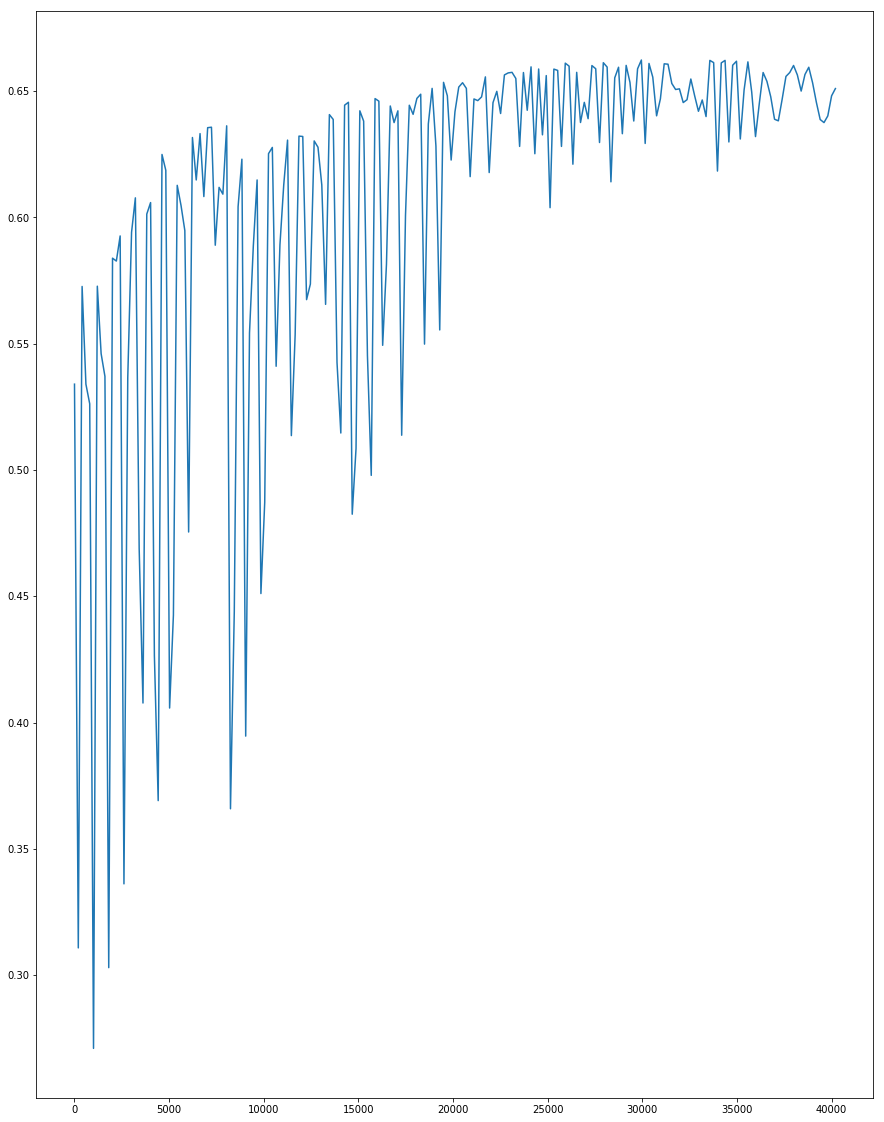

In [65]:
plt.figure(1, figsize=(15, 20))
plt.plot(np.arange(N_STEPS+1) * (BATCH_SIZE + 1), accuracies)
print('MAX ACCURACY:', max(accuracies))
plt.show()

# [Дополнительное исследование]
В классическом Aclive Learning в качестве "уверенности" для задач классификации выступает максимум вероятностей. Попробуем в качестве "уверенности" использовать разницу между top_1 и top_2 probabilities. Если она маленькая, то модель не уверена, какой из двух классов лучше выбрать.

In [40]:
BATCH_SIZE = 200
N_STEPS = 200
active_learning_model_2 = build_model(128, 'relu')
active_learning_model_2.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
remaining_samples = np.arange(len(X_train))
chosen = np.random.choice(remaining_samples, BATCH_SIZE, replace=False)
remaining_samples = remaining_samples[~np.isin(remaining_samples, chosen)]

active_learning_model_2.fit(X_train[chosen], y_train[chosen])
accuracies_2 = [active_learning_model_2.evaluate(X_test, y_test)[1]]
for step in range(N_STEPS):
    predicted = np.sort(active_learning_model_2.predict_proba(X_train[remaining_samples]))
    
    predicted_max = predicted[:, predicted.shape[1] - 1] - predicted[:, predicted.shape[1] - 2]
    
    batch_mask = remaining_samples[predicted_max.argsort()[:BATCH_SIZE]]
    
    active_learning_model_2.fit(X_train[batch_mask], y_train[batch_mask])
    remaining_samples = remaining_samples[~np.isin(remaining_samples, batch_mask)]
    acc = active_learning_model_2.evaluate(X_test, y_test)[1]
    accuracies_2.append(acc)
    print('Step %d: accuracy on test %.4f' % (step + 1, acc))

MAX ACCURACY: 0.6669112790608044


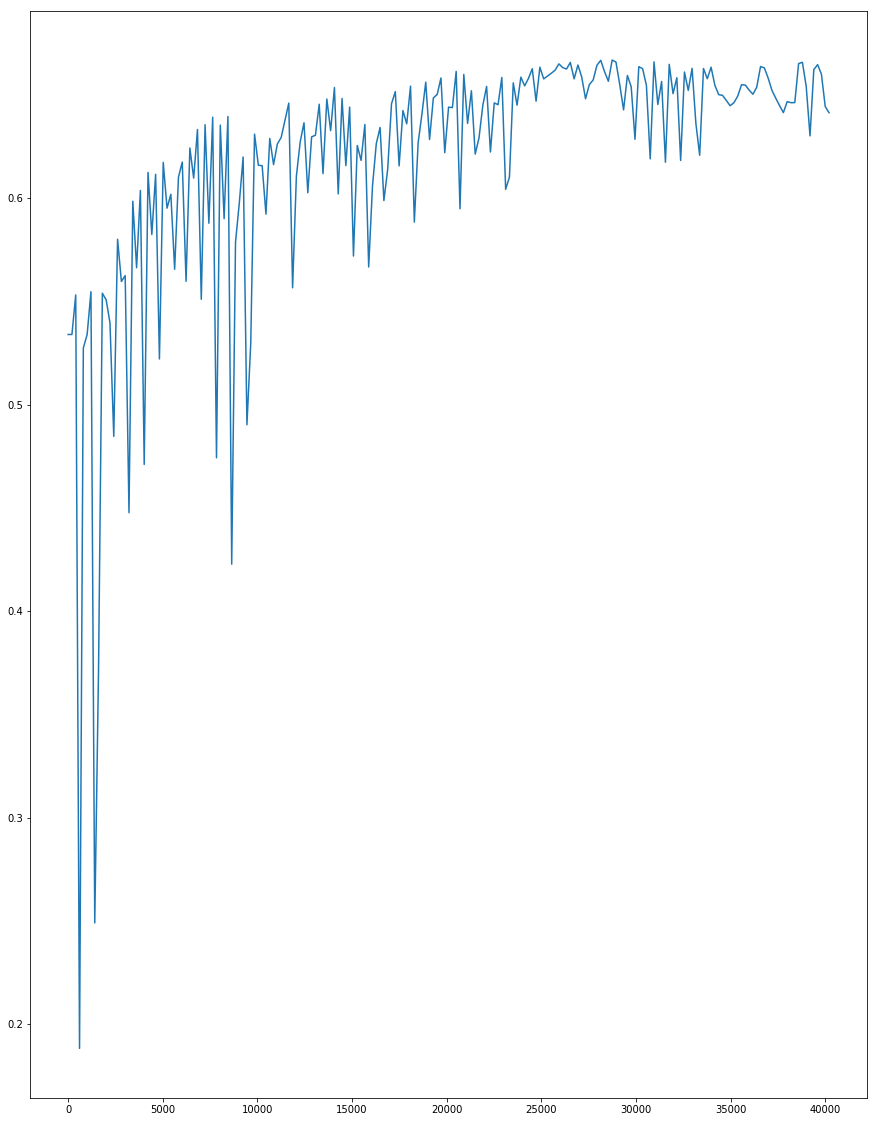

In [66]:
plt.figure(1, figsize=(15, 20))
plt.plot(np.arange(N_STEPS+1) * (BATCH_SIZE + 1), accuracies_2)
print('MAX ACCURACY:', max(accuracies_2))
plt.show()

# [Дополнительное исследование 2]
В классическом Aclive Learning'е ищется батч самых неуверенных объектов, после чего модель на них дообучается. Попробуем подмешивать в этот батч рандом в соотношении 3:1 (рандом:неуверенные)

In [55]:
BATCH_SIZE = 200
RANDOM_SIZE = 150
N_STEPS = 200
active_learning_model_3 = build_model(128, 'relu')
active_learning_model_3.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
remaining_samples = np.arange(len(X_train))
chosen = np.random.choice(remaining_samples, BATCH_SIZE, replace=False)
remaining_samples = remaining_samples[~np.isin(remaining_samples, chosen)]

active_learning_model_3.fit(X_train[chosen], y_train[chosen])
accuracies_3 = [active_learning_model_3.evaluate(X_test, y_test)[1]]
for step in range(N_STEPS):
    predicted = active_learning_model_3.predict_proba(X_train[remaining_samples])
    predicted_max = predicted.max(axis=1)
    batch_mask = remaining_samples[predicted_max.argsort()[:(BATCH_SIZE - RANDOM_SIZE)]]
    remaining_samples = remaining_samples[~np.isin(remaining_samples, batch_mask)]
    
    random_mask = np.random.choice(remaining_samples, RANDOM_SIZE, replace=False)
    remaining_samples = remaining_samples[~np.isin(remaining_samples, random_mask)]
    
    mask = np.array(batch_mask.tolist() + random_mask.tolist())
    active_learning_model_3.fit(X_train[mask], y_train[mask])

    acc = active_learning_model_3.evaluate(X_test, y_test)[1]
    accuracies_3.append(acc)
    print('Step %d: accuracy on test %.4f' % (step + 1, acc))

MAX ACCURACY: 0.6720481397401056


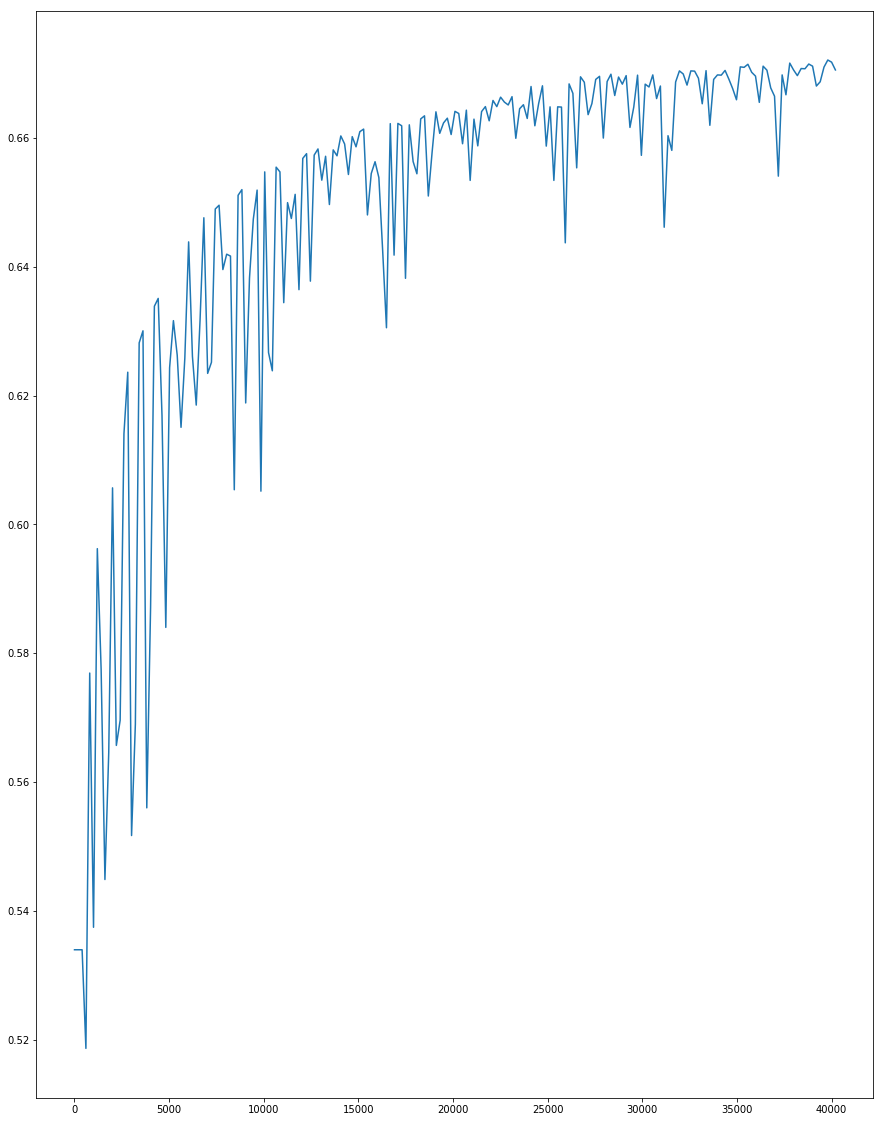

In [67]:
plt.figure(1, figsize=(15, 20))
plt.plot(np.arange(N_STEPS+1) * (BATCH_SIZE + 1), accuracies_3)
print('MAX ACCURACY:', max(accuracies_3))
plt.show()

# [Дополнительное исследование 3]
Применим два последних подхода вместе

In [69]:
BATCH_SIZE = 200
RANDOM_SIZE = 150
N_STEPS = 200
active_learning_model_4 = build_model(128, 'relu')
active_learning_model_4.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
remaining_samples = np.arange(len(X_train))
chosen = np.random.choice(remaining_samples, BATCH_SIZE, replace=False)
remaining_samples = remaining_samples[~np.isin(remaining_samples, chosen)]

active_learning_model_4.fit(X_train[chosen], y_train[chosen])
accuracies_4 = [active_learning_model_4.evaluate(X_test, y_test)[1]]
for step in range(N_STEPS):
    predicted = np.sort(active_learning_model_2.predict_proba(X_train[remaining_samples]))
    
    predicted_max = predicted[:, predicted.shape[1] - 1] - predicted[:, predicted.shape[1] - 2]
    
    batch_mask = remaining_samples[predicted_max.argsort()[:(BATCH_SIZE - RANDOM_SIZE)]]
    
    remaining_samples = remaining_samples[~np.isin(remaining_samples, batch_mask)]
    
    random_mask = np.random.choice(remaining_samples, RANDOM_SIZE, replace=False)
    remaining_samples = remaining_samples[~np.isin(remaining_samples, random_mask)]
    
    mask = np.array(batch_mask.tolist() + random_mask.tolist())
    active_learning_model_4.fit(X_train[mask], y_train[mask])

    acc = active_learning_model_4.evaluate(X_test, y_test)[1]
    accuracies_4.append(acc)
    print('Step %d: accuracy on test %.4f' % (step + 1, acc))

MAX ACCURACY: 0.6724884420810463


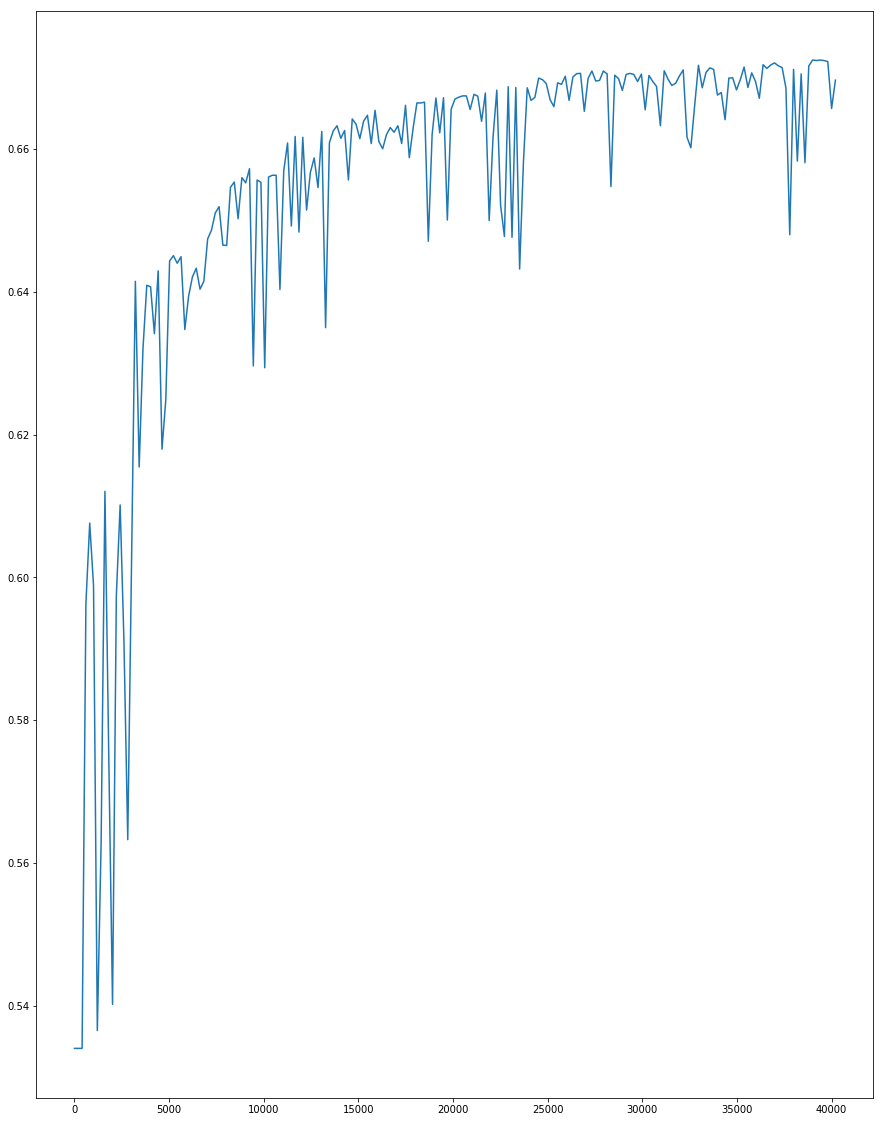

In [71]:
plt.figure(1, figsize=(15, 20))
plt.plot(np.arange(N_STEPS+1) * (BATCH_SIZE + 1), accuracies_4)
print('MAX ACCURACY:', max(accuracies_4))
plt.show()

# [ИТОГ]
- при обучении AL сильно нестабилен (графики сильно скачут), что достаточно логично, потому что каждая пачка объектов отличается от обучающей выборки на данный момент и смещает алгоритм под себя. К тому же, важную роль играет размер обучающей выборки
- Если при обучении добавлять не только трудные объекты, а еще рандомные, то графики стабильнее и результат лучше. Среди random_part in [0.25, 0.5, 0.75] лучше всего получилось с 0.75.
- Среди рассмотренных метрик "трудности" лучше всего, но не сильно, работает prob_(1) - prob_(2), то есть сомнение между первым и вторым по вероятности классом.
- Главный итог. С помощью обучения на части выборки удалось получить результат, сопоставимый с baseline. В лучшем случае, результат отличается всего на 0.002 accuracy при обучении на 55% выборки.

## Почему бейзлайн не покорен
- Он не должен быть покорен. Мы обучались на сильно меньшей части выборки.
- Плохая архитертура нейронной сети. Полносвязные слои склонны к переобучению, а в AL подаются трудные объекты, в том числе выбросы
- Неправильно подобранный размер BATCH_SIZE (хотя небольшой перебор [100, 200, 500] ни к чему не привел)

p.s. вывод keras'а при обучении был удален специально, чтобы логи не увеличивали размер ipynb/html в 2 раза